In [1]:
!unzip /content/sample_data/processed.zip -d /content/sample_data/

Archive:  /content/sample_data/processed.zip
   creating: /content/sample_data/processed/
   creating: /content/sample_data/processed/10/
   creating: /content/sample_data/processed/10/abnormal/
  inflating: /content/sample_data/processed/10/abnormal/11_77_97_203_226_237_274_.csv  
  inflating: /content/sample_data/processed/10/abnormal/106_123_183_207_.csv  
  inflating: /content/sample_data/processed/10/abnormal/12_689_721_850_.csv  
  inflating: /content/sample_data/processed/10/abnormal/13_30_35_56_62_71_93_98_105_126_165_211_289_295_312_325_365_372_379_391_406_427_.csv  
  inflating: /content/sample_data/processed/10/abnormal/151_.csv  
  inflating: /content/sample_data/processed/10/abnormal/19_94_.csv  
  inflating: /content/sample_data/processed/10/abnormal/202_283_495_.csv  
  inflating: /content/sample_data/processed/10/abnormal/20_47_73_141_229_322_359_420_447_506_577_602_607_699_767_.csv  
  inflating: /content/sample_data/processed/10/abnormal/220_263_300_.csv  
  inflating

In [3]:
# Install required packages (if not already installed in Colab)
!pip install numpy pandas scikit-learn matplotlib

# Import libraries
import os
import numpy as np
import pandas as pd
from typing import List, Dict
from dataclasses import dataclass
import math
import argparse
from google.colab import files  # For file upload in Colab
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import pointbiserialr

print("Dependencies and imports set up.")

Dependencies and imports set up.


Loaded 563_590_651_663_.csv from abnormal folder with 201 rows for track ID 563.
Loaded 151_.csv from abnormal folder with 412 rows for track ID 151.
Loaded 436_.csv from abnormal folder with 450 rows for track ID 436.
Loaded 361_.csv from abnormal folder with 24 rows for track ID 361.
Loaded 11_77_97_203_226_237_274_.csv from abnormal folder with 685 rows for track ID 11.
Loaded 736_791_886_.csv from abnormal folder with 261 rows for track ID 736.
Loaded 768_.csv from abnormal folder with 137 rows for track ID 768.
Loaded 835_.csv from abnormal folder with 329 rows for track ID 835.
Loaded 331_351_367_437_.csv from abnormal folder with 287 rows for track ID 331.
Loaded 591_.csv from abnormal folder with 1 rows for track ID 591.
Loaded 421_.csv from abnormal folder with 16 rows for track ID 421.
Loaded 396_.csv from abnormal folder with 425 rows for track ID 396.
Loaded 241_281_375_385_.csv from abnormal folder with 262 rows for track ID 241.
Loaded 823_.csv from abnormal folder with 2

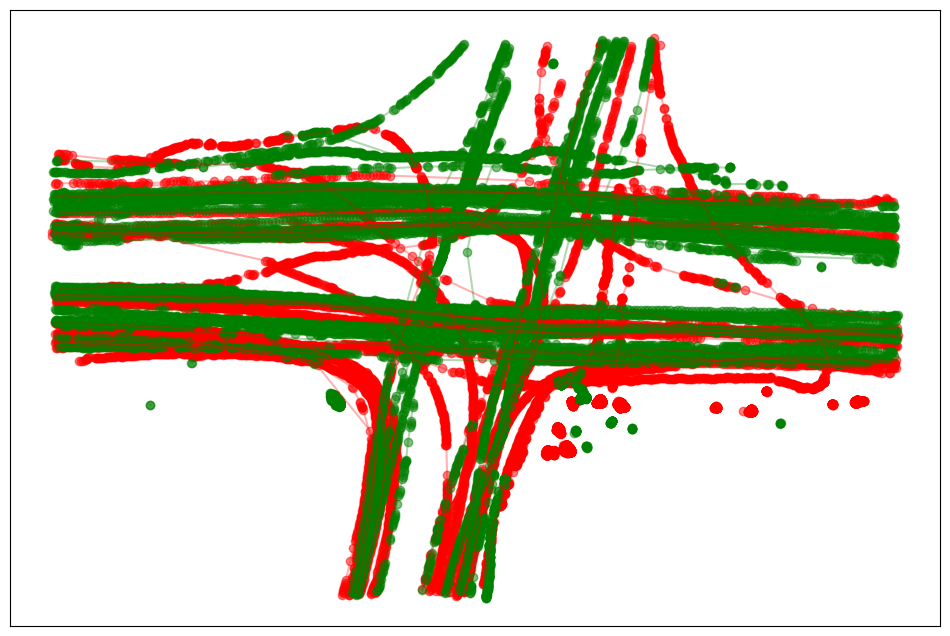

In [4]:
# Set the base directory containing the abnormal and normal subfolders
base_directory = '/content/sample_data/processed/10'

# Define subdirectories for abnormal and normal tracks
abnormal_dir = os.path.join(base_directory, 'abnormal')
normal_dir = os.path.join(base_directory, 'normal')

# Step 1: Load CSV files from both directories
def load_trajectories(abnormal_dir, normal_dir):
    tracks = {}

    # Load abnormal tracks
    if os.path.exists(abnormal_dir):
        abnormal_files = [f for f in os.listdir(abnormal_dir) if f.endswith('.csv')]
        for csv_file in abnormal_files:
            file_path = os.path.join(abnormal_dir, csv_file)
            try:
                df = pd.read_csv(file_path)[['frameNo', 'left', 'top', 'w', 'h']]
                if not df.empty:
                    # Extract track ID (first number before '_', or full filename if no '_')
                    track_id = csv_file.split('_')[0] if '_' in csv_file else csv_file.replace('.csv', '')
                    tracks[track_id] = {'df': df, 'label': 0}  # 0 for abnormal
                    print(f"Loaded {csv_file} from abnormal folder with {len(df)} rows for track ID {track_id}.")
                else:
                    print(f"Warning: {csv_file} is empty and will be skipped.")
            except Exception as e:
                print(f"Error loading {csv_file} from abnormal folder: {e}")
    else:
        print(f"Warning: Abnormal directory {abnormal_dir} not found.")

    # Load normal tracks
    if os.path.exists(normal_dir):
        normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.csv')]
        for csv_file in normal_files:
            file_path = os.path.join(normal_dir, csv_file)
            try:
                df = pd.read_csv(file_path)[['frameNo', 'left', 'top', 'w', 'h']]
                if not df.empty:
                    # Extract track ID (first number before '_', or full filename if no '_')
                    track_id = csv_file.split('_')[0] if '_' in csv_file else csv_file.replace('.csv', '')
                    tracks[track_id] = {'df': df, 'label': 1}  # 1 for normal
                    print(f"Loaded {csv_file} from normal folder with {len(df)} rows for track ID {track_id}.")
                else:
                    print(f"Warning: {csv_file} is empty and will be skipped.")
            except Exception as e:
                print(f"Error loading {csv_file} from normal folder: {e}")
    else:
        print(f"Warning: Normal directory {normal_dir} not found.")

    return tracks

# Step 2: Compute centers
def compute_centers(tracks):
    for track_id, data in tracks.items():
        df = data['df']
        df['center_x'] = df['left'] + df['w'] / 2
        df['center_y'] = df['top'] + df['h'] / 2

# Step 3: Plot all trajectories in one image
def plot_all_trajectories(tracks):
    plt.figure(figsize=(12, 8))
    colors = {'0': 'red', '1': 'green'}  # Red for abnormal, Green for normal

    for track_id, data in tracks.items():
        df = data['df']
        label = str(data['label'])
        color = colors[label]

        # Plot the trajectory without labels
        plt.scatter(df['center_x'], df['center_y'], c=color, alpha=0.5)
        plt.plot(df['center_x'], df['center_y'], c=color, alpha=0.3)

    # Remove labels, title, and legend
    plt.title('')  # Empty title
    plt.xlabel('')  # Empty x-axis label
    plt.ylabel('')  # Empty y-axis label
    plt.grid(False)  # No grid
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

    # Save the plot as an image
    output_path = os.path.join(base_directory, 'all_trajectories.png')
    plt.savefig(output_path, bbox_inches='tight')
    print(f"Saved plot to {output_path}")

    # Show the plot
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load trajectories from both folders
    tracks = load_trajectories(abnormal_dir, normal_dir)
    if not tracks:
        print("No valid trajectories loaded. Exiting.")
        exit()

    # Compute centers
    compute_centers(tracks)

    # Plot all trajectories in one image
    plot_all_trajectories(tracks)

In [6]:
# Define a data class for a vehicle's track point
@dataclass
class TrackPoint:
    frame_id: int  # Frame number from CSV (continuous)
    x: float       # 'left' coordinate of bounding box
    y: float       # 'top' coordinate of bounding box
    zone_id: int   # Assigned zone ID

VehicleTrack = List[TrackPoint]

# Define the TrafficAnalyzer class for feature extraction
class TrafficAnalyzer:
    def __init__(self, fps: float, speed_limit: float, zone_definitions: Dict,
                 violation_dict: Dict[str, List[str]], gsd: float):
        """Initialize with project-specific parameters."""
        self.fps = fps
        self.speed_limit = speed_limit
        self.zone_definitions = zone_definitions
        self.violation_dict = violation_dict
        self.gsd = gsd

    def calculate_speed(self, track: VehicleTrack) -> List[float]:
        """Calculate speed using frame differences as time intervals."""
        speeds = []
        for i in range(1, len(track)):
            dx = (track[i].x - track[i-1].x) * self.gsd
            dy = (track[i].y - track[i-1].y) * self.gsd
            distance = math.sqrt(dx**2 + dy**2)
            time = (track[i].frame_id - track[i-1].frame_id) / self.fps
            speed_mps = distance / time if time > 0 else 0
            speed_kmph = speed_mps * 3.6
            speeds.append(speed_kmph)
        return speeds

    def calculate_turn_angle(self, track: VehicleTrack) -> List[float]:
        """Calculate turn angles using three consecutive points."""
        angles = []
        for i in range(2, len(track)):
            v1 = (track[i-1].x - track[i-2].x, track[i-1].y - track[i-2].y)
            v2 = (track[i].x - track[i-1].x, track[i].y - track[i-1].y)
            dot_product = v1[0] * v2[0] + v1[1] * v2[1]
            mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
            mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
            if mag_v1 * mag_v2 == 0:
                angles.append(0)
                continue
            cos_theta = dot_product / (mag_v1 * mag_v2)
            cos_theta = min(1.0, max(-1.0, cos_theta))
            angle = math.degrees(math.acos(cos_theta))
            angles.append(angle)
        return angles

    def get_zone_sequence(self, track: VehicleTrack) -> List[int]:
        """Get sequence of zones traversed."""
        return [point.zone_id for point in track]

    def detect_abnormalities(self, track: VehicleTrack) -> Dict[str, bool]:
        """Detect abnormalities based on spatio-temporal features."""
        abnormalities = {
            'over_speeding': False,
            'wrong_side': False,
            'wrong_turn': False,
            'sharp_turn': False
        }
        speeds = self.calculate_speed(track)
        if speeds and max(speeds) > self.speed_limit:
            abnormalities['over_speeding'] = True

        zone_seq = self.get_zone_sequence(track)
        seq_str = ''.join(map(str, zone_seq))
        for wrong_side_seq in self.violation_dict.get('wrong_side', []):
            if wrong_side_seq in seq_str:
                abnormalities['wrong_side'] = True
                break
        for wrong_turn_seq in self.violation_dict.get('wrong_turn', []):
            if wrong_turn_seq in seq_str:
                abnormalities['wrong_turn'] = True
                break

        angles = self.calculate_turn_angle(track)
        if angles and max(angles) > 90:
            abnormalities['sharp_turn'] = True

        return abnormalities

print("TrafficAnalyzer class defined.")

TrafficAnalyzer class defined.


In [7]:
def assign_zone_id(x: float, y: float) -> int:
    """Assign zone based on coordinates (customize for your road layout)."""
    if x < 250:
        return 1  # Example: North zone
    elif 250 <= x < 300:
        return 2  # Example: Middle zone
    else:
        return 3  # Example: South zone

def convert_df_to_track(df: pd.DataFrame) -> VehicleTrack:
    """Convert a DataFrame trajectory to a VehicleTrack."""
    track = []
    for _, row in df.iterrows():
        x = row['left']
        y = row['top']
        frame_id = int(row['frameNo'])
        zone_id = assign_zone_id(x, y)
        track.append(TrackPoint(frame_id=frame_id, x=x, y=y, zone_id=zone_id))
    return track

print("Helper functions defined.")

Helper functions defined.


In [8]:
def load_trajectories(video_folder: str) -> tuple[List[pd.DataFrame], List[int]]:
    """
    Load trajectory data from CSV files in a video folder.

    Parameters:
    - video_folder (str): Path to the video folder (e.g., '/content/sample_data/processed/10')

    Returns:
    - trajectories (list): List of pandas DataFrames, each containing a trajectory
    - labels (list): List of labels (0 for normal, 1 for abnormal)
    """
    normal_path = os.path.join(video_folder, 'normal')
    abnormal_path = os.path.join(video_folder, 'abnormal')

    trajectories = []
    labels = []

    # Load normal trajectories
    if os.path.exists(normal_path):
        normal_files = [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith('.csv')]
        for file in normal_files:
            df = pd.read_csv(file)
            df = df[['frameNo', 'left', 'top', 'w', 'h']]
            df = df.sort_values(by='frameNo')
            trajectories.append(df)
            labels.append(0)

    # Load abnormal trajectories
    if os.path.exists(abnormal_path):
        abnormal_files = [os.path.join(abnormal_path, f) for f in os.listdir(abnormal_path) if f.endswith('.csv')]
        for file in abnormal_files:
            df = pd.read_csv(file)
            df = df[['frameNo', 'left', 'top', 'w', 'h']]
            df = df.sort_values(by='frameNo')
            trajectories.append(df)
            labels.append(1)

    return trajectories, labels

print("Trajectory loading function defined.")

Trajectory loading function defined.


In [9]:
def extract_features_for_all_trajectories(trajectories: List[pd.DataFrame], labels: List[int],
                                         analyzer: TrafficAnalyzer) -> pd.DataFrame:
    """
    Extract features and detect abnormalities for all trajectories.

    Parameters:
    - trajectories: List of DataFrames with trajectory data
    - labels: List of labels (0=normal, 1=abnormal)
    - analyzer: TrafficAnalyzer instance

    Returns:
    - results_df: DataFrame with features and abnormalities
    """
    results = []
    for idx, (traj_df, label) in enumerate(zip(trajectories, labels)):
        track = convert_df_to_track(traj_df)
        abnormalities = analyzer.detect_abnormalities(track)
        speeds = analyzer.calculate_speed(track)
        angles = analyzer.calculate_turn_angle(track)
        zone_seq = analyzer.get_zone_sequence(track)

        result = {
            'track_id': idx + 1,
            'label': label,
            'over_speeding': abnormalities['over_speeding'],
            'wrong_side': abnormalities['wrong_side'],
            'wrong_turn': abnormalities['wrong_turn'],
            'sharp_turn': abnormalities['sharp_turn'],
            'max_speed': max(speeds) if speeds else 0.0,
            'avg_speed': np.mean(speeds) if speeds else 0.0,
            'max_turn_angle': max(angles) if angles else 0.0,
            'avg_turn_angle': np.mean(angles) if angles else 0.0,
            'zone_sequence': ','.join(map(str, zone_seq)),
            'num_points': len(track)
        }
        results.append(result)

    return pd.DataFrame(results)

print("Feature extraction function defined.")

Feature extraction function defined.


In [10]:
# Define base folder and video subfolders
base_folder = '/content/sample_data/processed'  # Adjust this path
video_folders = [
    os.path.join(base_folder, '10'),
    os.path.join(base_folder, '11'),
    os.path.join(base_folder, '12')
]

# Load all trajectories
all_trajectories = []
all_labels = []
for folder in video_folders:
    if os.path.exists(folder):
        traj, lbl = load_trajectories(folder)
        all_trajectories.extend(traj)
        all_labels.extend(lbl)
    else:
        print(f"Warning: Folder {folder} does not exist.")

print(f"Loaded {len(all_trajectories)} trajectories.")

# Initialize TrafficAnalyzer
zone_definitions = {
    1: {'type': 'entry', 'direction': 'N'},
    2: {'type': 'middle', 'direction': 'center'},
    3: {'type': 'exit', 'direction': 'S'}
}
violation_dict = {
    'wrong_side': ['31'],
    'wrong_turn': ['23']
}
analyzer = TrafficAnalyzer(
    fps=30.0,
    speed_limit=40.0,
    zone_definitions=zone_definitions,
    violation_dict=violation_dict,
    gsd=0.0396 * (50 ** 0.9478)
)

# Extract features
results_df = extract_features_for_all_trajectories(all_trajectories, all_labels, analyzer)

# Display results
print("\nSummary of Results:")
display(results_df[['track_id', 'label', 'over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn',
                   'max_speed', 'max_turn_angle']])

Loaded 786 trajectories.

Summary of Results:


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,max_speed,max_turn_angle
0,1,0,True,False,False,True,4187.845182,98.530766
1,2,0,True,False,False,True,2371.311327,135.000000
2,3,0,True,False,False,True,871.711380,180.000000
3,4,0,True,False,False,False,1248.422182,2.910838
4,5,0,True,False,False,True,3143.000080,171.027373
...,...,...,...,...,...,...,...,...
781,782,1,True,False,False,True,1820.186800,180.000000
782,783,1,True,False,False,False,3504.236380,90.000000
783,784,1,True,False,True,False,2794.919303,59.036243
784,785,1,True,False,False,False,2440.791865,59.036243


from matplotlib import pyplot as plt
_df_0['track_id'].plot(kind='hist', bins=20, title='track_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['max_speed'].plot(kind='hist', bins=20, title='max_speed')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['max_turn_angle'].plot(kind='hist', bins=20, title='max_turn_angle')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('over_speeding').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('wrong_side').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('wrong_turn').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('sharp_turn').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='track_id', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='label', y='max_speed', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='max_speed', y='max_turn_angle', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['track_id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('track_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('over_speeding')):
  _plot_series(series, series_name, i)
  fig.legend(title='over_speeding', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('track_id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['track_id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('track_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('wrong_side')):
  _plot_series(series, series_name, i)
  fig.legend(title='wrong_side', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('track_id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['track_id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('track_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('wrong_turn')):
  _plot_series(series, series_name, i)
  fig.legend(title='wrong_turn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('track_id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['track_id']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('track_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sharp_turn')):
  _plot_series(series, series_name, i)
  fig.legend(title='sharp_turn', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('track_id')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
_df_15['track_id'].plot(kind='line', figsize=(8, 4), title='track_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['max_speed'].plot(kind='line', figsize=(8, 4), title='max_speed')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['max_turn_angle'].plot(kind='line', figsize=(8, 4), title='max_turn_angle')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['wrong_side'].value_counts()
    for x_label, grp in _df_19.groupby('over_speeding')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('over_speeding')
_ = plt.ylabel('wrong_side')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['wrong_turn'].value_counts()
    for x_label, grp in _df_20.groupby('wrong_side')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('wrong_side')
_ = plt.ylabel('wrong_turn')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sharp_turn'].value_counts()
    for x_label, grp in _df_21.groupby('wrong_turn')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('wrong_turn')
_ = plt.ylabel('sharp_turn')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['over_speeding'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='track_id', y='over_speeding', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['wrong_side'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='track_id', y='wrong_side', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['wrong_turn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='track_id', y='wrong_turn', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['sharp_turn'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='track_id', y='sharp_turn', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [12]:
# Save results to CSV
results_df.to_csv('/content/sample_data/trajectory_features.csv', index=False)
print("Features saved to '/content/sample_data/trajectory_features.csv'")

Features saved to '/content/sample_data/trajectory_features.csv'


In [25]:
# Load the CSV file
features_df = pd.read_csv('/content/sample_data/trajectory_features.csv')  # Replace with your file path if different

# Display the first few rows to inspect the data
print("Original Data Sample:")
display(features_df.head())

# Identify and drop noisy columns
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
constant_cols = [col for col in numeric_cols if features_df[col].nunique() <= 1 or features_df[col].sum() == 0]
noisy_cols = ['max_speed', 'avg_speed', 'max_turn_angle', 'avg_turn_angle']  # Based on your data
cols_to_drop = list(set(constant_cols + noisy_cols))

# Drop noisy columns
cleaned_df = features_df.drop(columns=cols_to_drop)

# Convert boolean columns to integer (0 and 1) for analysis
bool_cols = ['over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn']
for col in bool_cols:
    cleaned_df[col] = cleaned_df[col].astype(int)

# Separate features (X) and labels (y)
X = cleaned_df.drop(columns=['track_id', 'label'])  # Features
y = cleaned_df['label']  # Labels

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = ['zone_sequence']

print("\nCleaned Data Sample (after dropping noisy columns):")
display(cleaned_df.head())
print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")
print("Data cleaned and prepared successfully.")

Original Data Sample:


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,max_speed,avg_speed,max_turn_angle,avg_turn_angle,zone_sequence,num_points
0,1,0,True,False,False,True,4187.845182,2086.527563,98.530766,7.751782,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",209
1,2,0,True,False,False,True,2371.311327,1076.843263,135.000000,16.373449,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",303
2,3,0,True,False,False,True,871.711380,259.433566,180.000000,26.254586,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",235
3,4,0,True,False,False,False,1248.422182,1234.409057,2.910838,2.910838,"3,3,3",3
4,5,0,True,False,False,True,3143.000080,1275.068980,171.027373,29.399710,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",69



Cleaned Data Sample (after dropping noisy columns):


,track_id,label,over_speeding,wrong_side,wrong_turn,sharp_turn,zone_sequence,num_points
0,1,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",209
1,2,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",303
2,3,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",235
3,4,0,1,0,0,0,"3,3,3",3
4,5,0,1,0,0,1,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...",69


Numeric Features: ['over_speeding', 'wrong_side', 'wrong_turn', 'sharp_turn', 'num_points']
Categorical Features: ['zone_sequence']
Data cleaned and prepared successfully.



Statistical Summary for Numeric Features by Class (Mean and Std Dev):


,Mean_Normal,Std_Normal,Mean_Abnormal,Std_Abnormal
over_speeding,0.949550,0.219070,0.978355,0.145838
wrong_side,0.018018,0.133136,0.012987,0.113464
wrong_turn,0.163964,0.370577,0.277056,0.448516
sharp_turn,0.448649,0.497805,0.714286,0.452735
num_points,208.809009,304.561298,416.757576,520.655659



Point-Biserial Correlation with Label (Numeric Features):


,Feature,Correlation
3,sharp_turn,0.242365
4,num_points,0.241647
2,wrong_turn,0.129481
0,over_speeding,0.065429
1,wrong_side,-0.017970


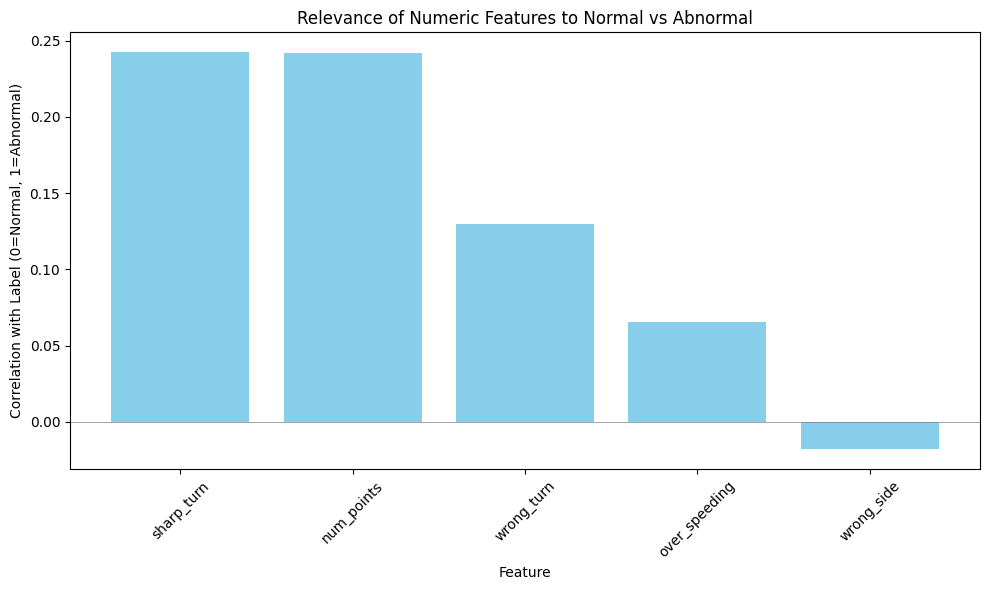


Zone Sequence Distribution by Label:


zone_sequence  1  1,1  1,1,1  1,1,1,1,1  1,1,1,1,1,1  1,1,1,1,1,1,1  \
label                                                                 
0              2    1      3          1            1              2   
1              0    0      0          0            0              0   

zone_sequence  1,1,1,1,1,1,1,1  1,1,1,1,1,1,1,1,1  1,1,1,1,1,1,1,1,1,1,1,1  \
label                                                                        
0                            1                  1                        1   
1                            0                  0                        0   

zone_sequence  1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1  ...  \
label                                             ...   
0                                              2  ...   
1                                              0  ...   

zone_sequence  3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,


Chi-Squared Test for zone_sequence vs Label:
Chi2 Statistic: 615.24, p-value: 0.1374
A low p-value (<0.05) indicates a significant association between zone_sequence and label.


In [28]:
# Calculate mean and standard deviation for numeric features only
normal_group = cleaned_df[cleaned_df['label'] == 0]
abnormal_group = cleaned_df[cleaned_df['label'] == 1]

mean_normal = normal_group[numeric_features].mean()
std_normal = normal_group[numeric_features].std()
mean_abnormal = abnormal_group[numeric_features].mean()
std_abnormal = abnormal_group[numeric_features].std()

stats_df = pd.DataFrame({
    'Mean_Normal': mean_normal,
    'Std_Normal': std_normal,
    'Mean_Abnormal': mean_abnormal,
    'Std_Abnormal': std_abnormal
})

print("\nStatistical Summary for Numeric Features by Class (Mean and Std Dev):")
display(stats_df)

# Compute point-biserial correlation between each numeric feature and the label
correlations = {}
for col in numeric_features:
    corr, _ = pointbiserialr(y, X[col])
    correlations[col] = corr

# Convert to DataFrame for display
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', key=abs, ascending=False)

print("\nPoint-Biserial Correlation with Label (Numeric Features):")
display(corr_df)

# Visualize correlation values for numeric features
plt.figure(figsize=(10, 6))
plt.bar(corr_df['Feature'], corr_df['Correlation'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.5)
plt.xlabel('Feature')
plt.ylabel('Correlation with Label (0=Normal, 1=Abnormal)')
plt.title('Relevance of Numeric Features to Normal vs Abnormal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze zone_sequence (categorical) separately using frequency distribution
zone_counts = cleaned_df.groupby(['label', 'zone_sequence']).size().unstack(fill_value=0)
print("\nZone Sequence Distribution by Label:")
display(zone_counts)

# Calculate a chi-squared test to assess association between zone_sequence and label
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(zone_counts)
print(f"\nChi-Squared Test for zone_sequence vs Label:")
print(f"Chi2 Statistic: {chi2:.2f}, p-value: {p:.4f}")
print("A low p-value (<0.05) indicates a significant association between zone_sequence and label.")

In [29]:
# Summary of findings
print("\nRelevance Assessment:")
print("- Numeric features with |Correlation| > 0.3 are strong indicators for classification.")
print("- Significant differences in means between normal and abnormal classes suggest relevance.")
print("- For zone_sequence, a low p-value (<0.05) in the chi-squared test indicates relevance.")

# Highlight strongly relevant numeric features
relevant_numeric_features = corr_df[abs(corr_df['Correlation']) > 0.3]['Feature'].tolist()
if relevant_numeric_features:
    print(f"Strongly relevant numeric features: {relevant_numeric_features}")
else:
    print("No numeric features with strong correlation (|corr| > 0.3).")

# Highlight zone_sequence relevance
if p < 0.05:
    print("zone_sequence appears relevant based on the chi-squared test (p < 0.05).")
else:
    print("zone_sequence may not be strongly relevant (p >= 0.05). Consider encoding or deriving new features from it.")

# Recommendations
print("\nRecommendations:")
if relevant_numeric_features or p < 0.05:
    print("- Some features appear relevant for distinguishing normal vs abnormal tracks.")
    print("- Proceed with these features for classification or further analysis.")
else:
    print("- Features lack strong relevance. Consider the following:")
    print("  - Verify data quality: Ensure trajectories capture meaningful motion (speed, turns, etc.).")
    print("  - Feature engineering: Derive new features (e.g., zone transitions, sequence length).")
    print("  - Expand dataset: Include more diverse trajectories to increase feature variation.")


Relevance Assessment:
- Numeric features with |Correlation| > 0.3 are strong indicators for classification.
- Significant differences in means between normal and abnormal classes suggest relevance.
- For zone_sequence, a low p-value (<0.05) in the chi-squared test indicates relevance.
No numeric features with strong correlation (|corr| > 0.3).
zone_sequence may not be strongly relevant (p >= 0.05). Consider encoding or deriving new features from it.

Recommendations:
- Features lack strong relevance. Consider the following:
  - Verify data quality: Ensure trajectories capture meaningful motion (speed, turns, etc.).
  - Feature engineering: Derive new features (e.g., zone transitions, sequence length).
  - Expand dataset: Include more diverse trajectories to increase feature variation.
